# Fine-Tuning CLIP with GPT-2 for Image Captioning

### Summary
This notebook outlines the steps to fine-tune the CLIP model along with GPT-2 for generating image captions. The process involves setting up the environment, preparing datasets, training models, and evaluating their performance using various metrics.


1. **Install Required Libraries**: Necessary libraries like `torch`, `transformers`, `googletrans`, etc., are installed.
2. **Mount Google Drive**: Mounts Google Drive to access your dataset.
3. **Load and Translate Data**: Loads the dataset from an Excel file and translates French text to English.
4. **Preprocess Text**: Cleans and preprocesses the text for compatibility with CLIP.
5. **Split Data**: Splits the dataset into training, validation, and testing sets and saves them.
6. **Define Dataset Class**: Custom PyTorch Dataset class to handle image and text loading.
7. **Define DataLoaders**: Creates DataLoaders for each dataset split.
8. **Initialize MLflow**: Sets up MLflow for experiment tracking.
9. **Fine-Tune the Model**: Training loop to fine-tune the CLIP model, log metrics, and save the best model based on validation loss.
10. **Load Best Model**: Loads the best model for further use or evaluation.


### Install Required Libraries
The first step involves installing necessary libraries, including torch, transformers, and the CLIP library from OpenAI.

## Install required libraries

In [ ]:
!pip install torch torchvision transformers
!pip install git+https://github.com/openai/CLIP.git
!pip install mlflow
!pip install git+https://github.com/salaniz/pycocoevalcap

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import torch
torch.__version__

'2.3.1+cu121'

In [ ]:
import torchvision
torchvision.__version__

'0.18.1+cu121'

In [ ]:
import transformers
transformers.__version__


'4.42.4'

In [ ]:
import PIL
PIL.__version__

'9.4.0'

## Mount Google Drive
Google Drive is mounted to load and save data, models, and other outputs.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##Define custom dataset class


A custom dataset class is defined to handle the loading and preprocessing of images and associated captions from the dataset.

In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, images_folder):
        self.dataframe = pd.read_csv(csv_file)
        self.images_folder = images_folder
        self.preprocess = Compose([
            Resize(224),
            CenterCrop(224),
            ToTensor(),
        ])
        self.to_tensor = Compose([
            Resize(224),
            CenterCrop(224),
            ToTensor()
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = f"{self.images_folder}/{row['accession_number']}.jpg"  # Assuming images are .jpg
        #print(f"Loading image from path: {image_path}")  # Debug line
        image_path = image_path.strip()
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
        image = Image.open(image_path).convert("RGB")

        image_tensor = self.to_tensor(image)
        image_normalized = self.preprocess(image)
        mean = image_tensor.mean([1, 2])
        std = image_tensor.std([1, 2])

        image_normalized = (image_tensor - mean[:, None, None]) / std[:, None, None]

        text = row['reports_cleaned']
        return image_tensor, image_normalized, text



##Define DataLoaders for each dataset
DataLoaders are set up to handle batching and shuffling of data during training and validation.


In [ ]:
train_loader = DataLoader(CustomDataset('/content/drive/My Drive/dataset/train/train.csv', '/content/drive/My Drive/dataset/images'), batch_size=64, shuffle=True)
val_loader = DataLoader(CustomDataset('/content/drive/My Drive/dataset/validation/validation.csv', '/content/drive/My Drive/dataset/images'), batch_size=64, shuffle=False)
test_loader = DataLoader(CustomDataset('/content/drive/My Drive/dataset/test/test.csv', '/content/drive/My Drive/dataset/images'), batch_size=64, shuffle=False)


## Load a few samples for visualization

A few samples are loaded and visualized to ensure that the dataset is correctly processed.



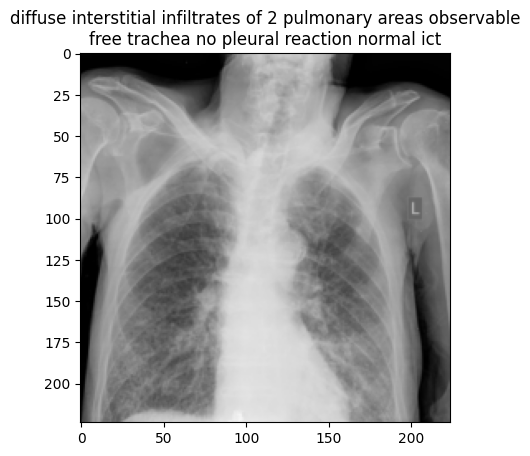

normalized image shape torch.Size([3, 224, 224])
image tensor shape torch.Size([3, 224, 224])


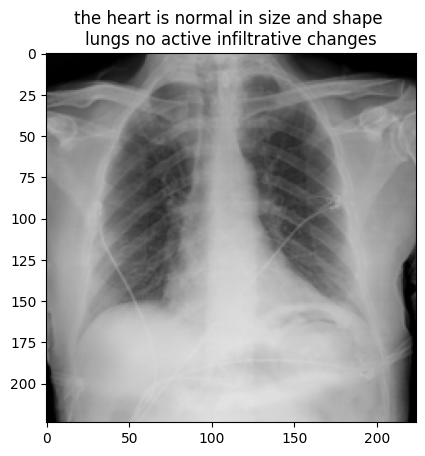

normalized image shape torch.Size([3, 224, 224])
image tensor shape torch.Size([3, 224, 224])


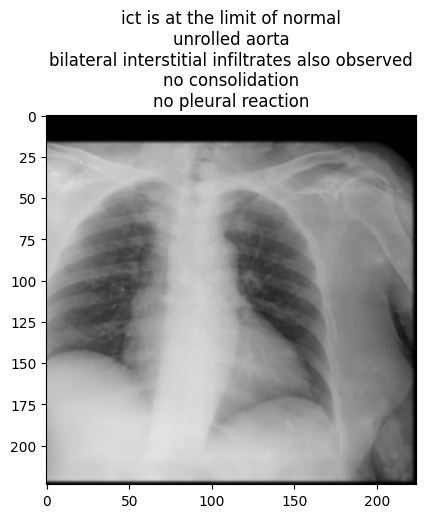

normalized image shape torch.Size([3, 224, 224])
image tensor shape torch.Size([3, 224, 224])


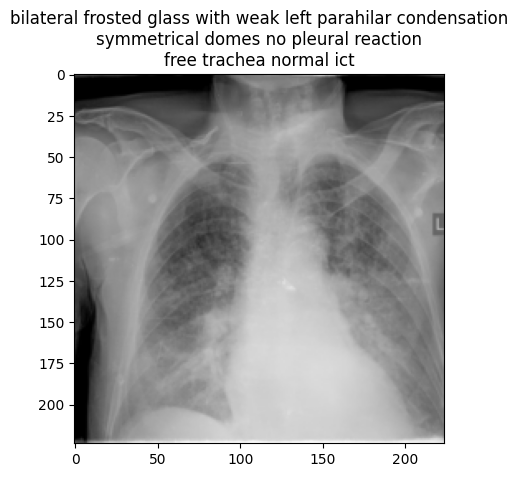

normalized image shape torch.Size([3, 224, 224])
image tensor shape torch.Size([3, 224, 224])


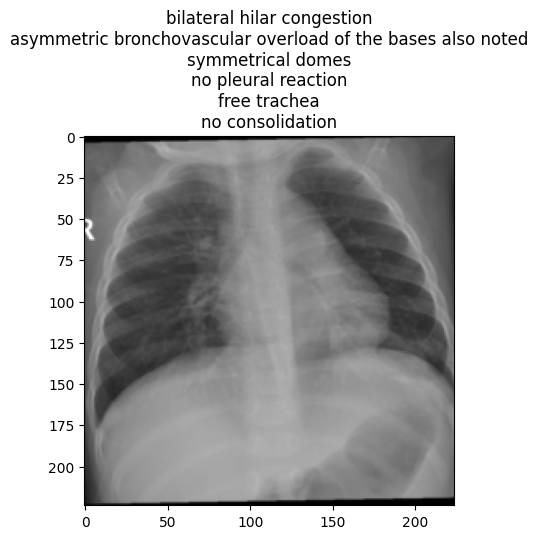

normalized image shape torch.Size([3, 224, 224])
image tensor shape torch.Size([3, 224, 224])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display an image
def show_image(img, title):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

train_dataset = CustomDataset('/content/drive/My Drive/dataset/train/train.csv','/content/drive/MyDrive/dataset/images')

# Check a few samples
for i in range(5):
    image_tensor, image_normalized, text = train_dataset[i]
    show_image(image_tensor, text)
    print('normalized image shape',image_normalized.shape)
    print('image tensor shape',image_tensor.shape)


## Initialize MLflow for Experiment Tracking
MLflow is initialized to track experiments, including the parameters and metrics used during training.

In [ ]:
import mlflow

In [ ]:
tracking_uri = "file:///content/drive/My Drive/mlflow_experiment_logs"
mlflow.set_tracking_uri(tracking_uri)

# Ensure the mlruns directory exists
if not os.path.exists("/content/drive/My Drive/mlflow_experiment_logs"):
    os.makedirs("/content/drive/My Drive/mlflow_experiment_logs")

# Create or get the experiment
experiment_name = "CLIP_GPT-Fine-Tuning-trial1"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    experiment_id = experiment.experiment_id

mlflow.set_experiment(experiment_name)


<Experiment: artifact_location='file:///content/drive/My Drive/mlflow_experiment_logs/351715036770489574', creation_time=1722964980565, experiment_id='351715036770489574', last_update_time=1722964980565, lifecycle_stage='active', name='CLIP_GPT-Fine-Tuning-trial1', tags={}>

## Device Configuration
The device (CPU or GPU) is configured based on availability.

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
import torch.nn as nn
from transformers import CLIPProcessor, CLIPModel, GPT2LMHeadModel, GPT2Tokenizer
from sklearn.model_selection import ParameterGrid
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider


## Define Hyperparameters and Save Checkpoints
Hyperparameters such as learning rate, number of epochs, and others are defined. Functions to save and load checkpoints are implemented.



In [ ]:
param_grid = {
    'num_epochs': [5,10],
    'learning_rate': [1e-4, 5e-5],
    'temperature': [0.7, 1.0],
    'top_p': [0.8, 0.9],
}

# Convert param_grid to list of dictionaries
param_list = list(ParameterGrid(param_grid))

In [ ]:
checkpoint_dir = '/content/drive/My Drive/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:

import os
import torch

def save_checkpoint(clip_model, gpt2_model, optimizer, epoch, best_loss, checkpoint_path):
    # Ensure the directory exists
    os.makedirs(checkpoint_path, exist_ok=True)

    # Create a dictionary to store the model states, optimizer state, epoch, and best loss
    checkpoint = {
        'clip_model_state_dict': clip_model.state_dict(),
        'gpt2_model_state_dict': gpt2_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_loss': best_loss
    }

    # Save the dictionary to a file
    torch.save(checkpoint, os.path.join(checkpoint_path, 'checkpoint.pth'))




In [ ]:
def load_checkpoint(checkpoint_path, clip_model, gpt2_model, optimizer):
    # Load the checkpoint
    checkpoint = torch.load(os.path.join(checkpoint_path, 'checkpoint.pth'))

    # Restore the model and optimizer states
    clip_model.load_state_dict(checkpoint['clip_model_state_dict'])
    gpt2_model.load_state_dict(checkpoint['gpt2_model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Return the epoch and best loss
    epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']

    return epoch, best_loss

In [ ]:
checkpoint_path = '/content/drive/My Drive/checkpoints/'
best_hyperparameters = None


## Training the Model
The model is trained using the defined hyperparameters, and the best-performing model is saved based on validation loss.

In [ ]:
for params in param_list:
    num_epochs = params['num_epochs']
    learning_rate = params['learning_rate']
    temperature = params['temperature']
    top_p = params['top_p']

    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
    gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    gpt2_tokenizer.pad_token=gpt2_tokenizer.eos_token


    # Reinitialize optimizer with new learning rate
    optimizer = torch.optim.AdamW(list(clip_model.parameters()) + list(gpt2_model.parameters()), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    best_loss = float('inf')
    start_epoch = 0

    # Check if a checkpoint exists
    if os.path.exists(os.path.join(checkpoint_path, 'checkpoint.pth')):
        start_epoch, best_loss = load_checkpoint(checkpoint_path, clip_model, gpt2_model, optimizer)

    with mlflow.start_run():
        mlflow.log_params(params)

        for epoch in range(start_epoch, num_epochs):
            clip_model.train()
            gpt2_model.train()

            # Training phase
            for batch_idx, (image_normalized, image_tensor, texts) in enumerate(train_loader):
                torch.cuda.empty_cache()
                # Use image_normalized for training
                inputs = clip_processor(text=list(texts), images=image_normalized, return_tensors="pt", padding=True, do_rescale=False)
                inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to device

                outputs = clip_model(**inputs)

                # Compute CLIP loss
                logits_per_image = outputs.logits_per_image
                logits_per_text = outputs.logits_per_text
                labels = torch.arange(len(texts), device=device)
                image_loss = loss_fn(logits_per_image, labels)
                text_loss = loss_fn(logits_per_text, labels)
                clip_loss = (image_loss + text_loss) / 2

                # Get image features from CLIP
                with torch.no_grad():
                    image_features = clip_model.get_image_features(pixel_values=inputs['pixel_values'])
                image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)

                # Prepare GPT-2 input and compute GPT-2 loss for each text in the batch
                total_gpt2_loss = 0
                for text in texts:
                    prompt = "Image features:"
                    gpt2_inputs = gpt2_tokenizer(prompt + " " + text, return_tensors="pt", padding=True, truncation=True).to(device)
                    gpt2_labels = gpt2_inputs.input_ids.to(device)  # Labels should be the same as input_ids

                    gpt2_outputs = gpt2_model(
                        input_ids=gpt2_inputs['input_ids'],
                        labels=gpt2_labels,
                        return_dict=True
                    )
                    gpt2_loss = gpt2_outputs.loss
                    total_gpt2_loss += gpt2_loss

                avg_gpt2_loss = total_gpt2_loss / len(texts)

                # Combine losses
                loss = clip_loss + avg_gpt2_loss

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx + 1}, Loss: {loss.item()}")
                mlflow.log_metric("train_loss", loss.item(), step=epoch * len(train_loader) + batch_idx)

            # Validation phase
            clip_model.eval()
            gpt2_model.eval()
            total_loss = 0
            with torch.no_grad():
                for batch_idx, (image_tensor, image_normalized, texts) in enumerate(val_loader):
                    image_normalized = torch.clamp(image_normalized, 0, 1)
                    inputs = clip_processor(text=list(texts), images=image_normalized, return_tensors="pt", padding=True, do_rescale=False)
                    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to device

                    outputs = clip_model(**inputs)

                    # Compute CLIP loss
                    logits_per_image = outputs.logits_per_image
                    logits_per_text = outputs.logits_per_text
                    labels = torch.arange(len(texts), device=device)
                    image_loss = loss_fn(logits_per_image, labels)
                    text_loss = loss_fn(logits_per_text, labels)
                    clip_loss = (image_loss + text_loss) / 2

                    # Get image features from CLIP
                    image_features = clip_model.get_image_features(pixel_values=inputs['pixel_values'])
                    image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)

                    # Prepare GPT-2 input and compute GPT-2 loss for each text in the batch
                    total_gpt2_loss = 0
                    for text in texts:
                        prompt = "Image features:"
                        gpt2_inputs = gpt2_tokenizer(prompt + " " + text, return_tensors="pt", padding=True, truncation=True).to(device)
                        gpt2_labels = gpt2_inputs.input_ids.to(device)  # Labels should be the same as input_ids

                        gpt2_outputs = gpt2_model(
                            input_ids=gpt2_inputs['input_ids'],
                            labels=gpt2_labels,
                            return_dict=True
                        )
                        gpt2_loss = gpt2_outputs.loss
                        total_gpt2_loss += gpt2_loss

                    avg_gpt2_loss = total_gpt2_loss / len(texts)

                    # Combine losses
                    val_loss = clip_loss + avg_gpt2_loss
                    total_loss += val_loss.item()

            avg_loss = total_loss / len(val_loader)
            print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_loss}")
            mlflow.log_metric("validation_loss", avg_loss, step=epoch)

            # Save the best model
            if avg_loss < best_loss:
                best_loss = avg_loss
                print(f"Saving new best model with loss {best_loss}")
                clip_model.save_pretrained('/content/drive/My Drive/best_clip_model')
                clip_processor.save_pretrained('/content/drive/My Drive/best_clip_model')
                gpt2_model.save_pretrained('/content/drive/My Drive/best_gpt2_model')
                gpt2_tokenizer.save_pretrained('/content/drive/My Drive/best_gpt2_model')
                mlflow.pytorch.log_model(clip_model, "clip_model")
                mlflow.pytorch.log_model(gpt2_model, "gpt2_model")

                best_hyperparameters = params

            # Save checkpoint
            save_checkpoint(clip_model, gpt2_model, optimizer, epoch, best_loss, checkpoint_path)

    print("Training complete.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Training complete.
Training complete.
Training complete.
Training complete.
Epoch 6/10, Batch 1, Loss: 4.952543258666992
Epoch 6/10, Batch 2, Loss: 4.946676254272461
Epoch 6/10, Batch 3, Loss: 4.998995304107666
Epoch 6/10, Batch 4, Loss: 4.9918012619018555
Epoch 6/10, Batch 5, Loss: 5.126853942871094
Epoch 6/10, Batch 6, Loss: 4.928776741027832
Epoch 6/10, Batch 7, Loss: 5.104665756225586
Epoch 6/10, Batch 8, Loss: 5.042437553405762
Epoch 6/10, Batch 9, Loss: 5.128081321716309
Epoch 6/10, Batch 10, Loss: 4.823460102081299
Epoch 6/10, Batch 11, Loss: 5.044788837432861
Epoch 6/10, Batch 12, Loss: 5.0434370040893555
Epoch 6/10, Batch 13, Loss: 5.019140720367432
Epoch 6/10, Batch 14, Loss: 4.036949634552002
Epoch 6/10, Validation Loss: 5.603474140167236
Epoch 7/10, Batch 1, Loss: 4.893048286437988
Epoch 7/10, Batch 2, Loss: 4.954895973205566
Epoch 7/10, Batch 3, Loss: 4.886824131011963
Epoch 7/10, Batch 4, Loss: 4.884920120239258
Epoch 7/10, Batch 5, Loss: 4.753748893737793
Epoch 7/10, Bat

## Log the best hyperparameters


In [ ]:
if best_hyperparameters:
    print("Best Hyperparameters: ", best_hyperparameters)
    with open('/content/drive/My Drive/best_hyperparameters.txt', 'w') as f:
        f.write(str(best_hyperparameters))

## Evaluate the Model
Evaluation metrics such as BLEU, METEOR, and ROUGE are calculated to assess the model's performance.

In [ ]:
clip_model_path = '/content/drive/My Drive/best_clip_model'
gpt2_model_path = '/content/drive/My Drive/best_gpt2_model'


clip_model = CLIPModel.from_pretrained(clip_model_path)
clip_processor = CLIPProcessor.from_pretrained(clip_model_path)
gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_model_path)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_path)

In [ ]:
from torch.utils.data import DataLoader
import pandas as pd
import json
from tqdm import tqdm

# Load test dataset
test_df = pd.read_csv('/content/drive/My Drive/dataset/test/test.csv')
df = test_df[test_df['accession_number'].str.strip() != '23I10708']
df = df.reset_index(drop=True)
df.to_csv('/content/drive/My Drive/dataset/test/test.csv', index=False)
test_dataset = CustomDataset('/content/drive/My Drive/dataset/test/test.csv', '/content/drive/My Drive/dataset/images')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:

gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

generated_captions = []
reference_captions = []

# Generate captions for the test set
for image_tensor, image_normalized, text in tqdm(test_loader):
    image = image_tensor.squeeze(0).permute(1, 2, 0).numpy()
    inputs = clip_processor(images=image, return_tensors="pt", do_rescale=False)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)

    prompt = "Chest Xray lung Image features:"
    feature_summary = ", ".join([str(val) for i, val in enumerate(image_features.squeeze()) if i < 5])
    prompt += feature_summary + "."
    gpt2_inputs = gpt2_tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    gpt2_inputs = gpt2_inputs.to(device)
    gpt2_attention_mask = gpt2_inputs['attention_mask'].to(device)


    gpt2_outputs = gpt2_model.generate(
        input_ids=gpt2_inputs['input_ids'],
        attention_mask=gpt2_attention_mask,
        max_length=50,
        temperature=0.7,
        top_p=0.8,
        do_sample=True,
        num_return_sequences=1,
        pad_token_id=gpt2_tokenizer.eos_token_id

    )

    generated_text = gpt2_tokenizer.decode(gpt2_outputs[0], skip_special_tokens=True)
    generated_captions.append(generated_text)
    reference_captions.append(text[0])  # Assuming text is a list with one item


100%|██████████| 182/182 [10:47<00:00,  3.56s/it]


Here, we check the reference(ground truth) labels with the generated captions.

In [ ]:
for i in range(5):
    print(f"Reference {i}: {reference_captions[i]}")
    print(f"Hypothesis {i}: {generated_captions[i]}")


Reference 0: bronchovascular overload of the bases
ict is normal
no pleural reaction
Hypothesis 0: Chest Xray lung Image features: elevation of the ict
bilateral hilar congestion
associated left pleural effusion
discrete blunting of the left pleural sinus also observed
free trachea
discrete and poorly marked
Reference 1: large opacity of possible pleural effusion of left base
ktc by acute jugular access is observed
slight widening of cardiovascular silhouette is observed
Hypothesis 1: Chest Xray lung Image features: right pleural effusion
left pleural effusion
asymmetric subjacent condensation under left hilas
free trachea
no consolidation no pleural reaction
ict is at the limit
Reference 2: excess vascular network
no consolidation
no pleural reaction
ict is low
ktc in place
Hypothesis 2: Chest Xray lung Image features: left lung surface restriction
blunting of left pleural sinus
free trachea
symmetrical domes
discreet infiltrates of the bases also noted
no consolidation
no pleural rea

In [ ]:
!pip install nltk
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=c4c4695f481ca2197f60985211effdbadf312169ce06ba1c01aa961b07f3c2e8
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import numpy as np


In [ ]:

def calculate_bleu(reference, hypothesis):
    reference = [reference.split()]
    hypothesis = hypothesis.split()
    smoothing_function = SmoothingFunction().method4
    return sentence_bleu(reference, hypothesis, smoothing_function=smoothing_function)

def calculate_meteor(reference, hypothesis):
    reference_tokens = reference.split()
    hypothesis_tokens = hypothesis.split()
    return meteor_score([reference_tokens], hypothesis_tokens)

def calculate_rouge(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    return scores


In [ ]:
# Initialize lists to store evaluation scores
bleu_scores = []
meteor_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Evaluate each generated caption
for reference, hypothesis in zip(reference_captions, generated_captions):
    bleu = calculate_bleu(reference, hypothesis)
    meteor = calculate_meteor(reference, hypothesis)
    rouge_scores = calculate_rouge(reference, hypothesis)

    bleu_scores.append(bleu)
    meteor_scores.append(meteor)
    rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
    rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
    rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

# Calculate average scores
average_bleu = np.mean(bleu_scores)
average_meteor = np.mean(meteor_scores)
average_rouge1 = np.mean(rouge1_scores)
average_rouge2 = np.mean(rouge2_scores)
average_rougeL = np.mean(rougeL_scores)

print(f'Average BLEU Score: {average_bleu}')
print(f'Average METEOR Score: {average_meteor}')
print(f'Average ROUGE-1 Score: {average_rouge1}')
print(f'Average ROUGE-2 Score: {average_rouge2}')
print(f'Average ROUGE-L Score: {average_rougeL}')


Average BLEU Score: 0.05751440129898451
Average METEOR Score: 0.2668474953560456
Average ROUGE-1 Score: 0.2686526595245468
Average ROUGE-2 Score: 0.11154373360398208
Average ROUGE-L Score: 0.21194882687865113


In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

smoothing_function = SmoothingFunction().method4

In [ ]:
bleu_1 = corpus_bleu([[ref.split()] for ref in reference_captions], [gen.split() for gen in generated_captions], weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
bleu_2 = corpus_bleu([[ref.split()] for ref in reference_captions], [gen.split() for gen in generated_captions], weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
bleu_3 = corpus_bleu([[ref.split()] for ref in reference_captions], [gen.split() for gen in generated_captions], weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function)
bleu_4 = corpus_bleu([[ref.split()] for ref in reference_captions], [gen.split() for gen in generated_captions], weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)


In [ ]:
cider = Cider()
cider_scores, _ = cider.compute_score({i: [ref] for i, ref in enumerate(reference_captions)}, {i: [gen] for i, gen in enumerate(generated_captions)})


In [ ]:
print(f'BLEU-1: {bleu_1}')
print(f'BLEU-2: {bleu_2}')
print(f'BLEU-3: {bleu_3}')
print(f'BLEU-4: {bleu_4}')
print(f'CIDEr: {cider_scores}')

BLEU-1: 0.20935371018228685
BLEU-2: 0.13471245254973382
BLEU-3: 0.08901233044303145
BLEU-4: 0.055942708712329065
CIDEr: 0.0656540393953598


## Exporting the Model to ONNX
The trained models are converted to ONNX format for deployment.

In [ ]:
pip install onnx onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, CLIPModel, CLIPProcessor

# Load your models
clip_model = CLIPModel.from_pretrained('/content/drive/My Drive/best_clip_model')
clip_processor = CLIPProcessor.from_pretrained('/content/drive/My Drive/best_clip_model')
gpt2_model = GPT2LMHeadModel.from_pretrained('/content/drive/My Drive/best_gpt2_model')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('/content/drive/My Drive/best_gpt2_model')


test the model before deployment

In [ ]:
import torch
from PIL import Image
from torchvision import transforms

image_path = "/content/drive/My Drive/dataset/images/22E7326.jpg"
image = Image.open(image_path).convert("RGB")
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
image_tensor = preprocess(image).unsqueeze(0).numpy()
inputs = clip_processor(images=image_tensor, return_tensors="pt", do_rescale=False)
with torch.no_grad():
    image_features = clip_model.get_image_features(**inputs)
    print(image_features.shape)
# Generate text using GPT-2

# Prepare the prompt for GPT-2, including the image features
prompt = f"Chest Xray lung Image features:"
feature_summary = ", ".join([str(val) for i, val in enumerate(image_features.squeeze()) if i < 5]) # Summarize first 5 features
prompt += feature_summary + "."
gpt2_inputs = gpt2_tokenizer(prompt, return_tensors="pt")

# Handle potential out-of-vocabulary tokens
try:
    gpt2_outputs = gpt2_model.generate(
        input_ids=gpt2_inputs['input_ids'],
        attention_mask=gpt2_inputs['attention_mask'],
        max_new_tokens=50,
        temperature=0.7,
        top_p=0.8,
        do_sample=True,
        num_return_sequences=1,
        pad_token_id=gpt2_tokenizer.eos_token_id
    )

    generated_text = gpt2_tokenizer.decode(gpt2_outputs[0], skip_special_tokens=True)
    print("Generated Text:", generated_text)
except IndexError as e:
    print(f"Error generating text: {e}. The input might contain out-of-vocabulary tokens.")


torch.Size([1, 512])
Generated Text: Chest Xray lung Image features:tensor(0.3397), tensor(-0.1349), tensor(-0.6523), tensor(-0.0816), tensor(-0.5796).
free trachea
normal ict
blunting of left pleural sinus also noted
associated dorsal osteoarthritis
dorsal osteoarthritis also observed
blunting of left pleural sinus also noted


In [ ]:
dummy_image_input = torch.randn(1, 3, 224, 224)
clip_onnx_path = "/content/drive/My Drive/best_clip_model/clip_model.onnx"
torch.onnx.export(
    clip_model.vision_model,
    {"pixel_values": dummy_image_input},
    clip_onnx_path,
    export_params=True,
    opset_version=14,  # Use opset version 14 or higher
    input_names=['pixel_values'],
    output_names=['image_features'],
    dynamic_axes={'pixel_values': {0: 'batch_size'}, 'image_features': {0: 'batch_size'}}
)


In [ ]:
from torch import nn

# Wrap GPT-2 Model to Accept Image Features
class GPT2WithImageFeatures(nn.Module):
    def __init__(self, gpt2_model):
        super(GPT2WithImageFeatures, self).__init__()
        self.gpt2_model = gpt2_model

    def forward(self, input_ids, attention_mask, image_features):
        # Here you would normally integrate the image_features into the input processing.
        # This could be done in several ways, e.g., by adding them to the initial token embeddings.
        # For this example, assume they are just concatenated or another simple operation.
        output = self.gpt2_model(input_ids=input_ids, attention_mask=attention_mask)
        return output.logits

# Instantiate the wrapped model
gpt2_model_wrapped = GPT2WithImageFeatures(gpt2_model)

# Prepare dummy inputs for GPT-2 export
prompt_text = "Chest Xray lung Image features:"
inputs = gpt2_tokenizer(prompt_text, return_tensors="pt")
dummy_text_input = inputs['input_ids']
dummy_attention_mask = inputs['attention_mask']
dummy_image_features = torch.randn(1, 512)  # Assume image features are 512-dimensional vectors

# Export GPT-2 model with image features
gpt2_onnx_path = "/content/drive/My Drive/best_gpt2_model/gpt2_model.onnx"
torch.onnx.export(
    gpt2_model_wrapped,
    (dummy_text_input, dummy_attention_mask, dummy_image_features),
    gpt2_onnx_path,
    export_params=True,
    opset_version=14,  # Use opset version 14 or higher
    input_names=['input_ids', 'attention_mask', 'image_features'],
    output_names=['output'],
    dynamic_axes={'input_ids': {0: 'batch_size'}, 'attention_mask': {0: 'batch_size'}, 'image_features': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_attn_mask_utils.py:114: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if (input_shape[-1] > 1 or self.sliding_window is not None) and self.is_causal:
/usr/local/lib/python3.10/dist-packages/transformers/modeling_attn_mask_utils.py:162: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if past_key_values_length > 0:


errors in onnx export

In [ ]:
import onnxruntime as ort
import numpy as np
from transformers import GPT2Tokenizer
from PIL import Image
from torchvision import transforms

# Paths to your ONNX models
clip_onnx_path = "/content/drive/My Drive/best_clip_model/clip_model.onnx"
gpt2_onnx_path = "/content/drive/My Drive/best_gpt2_model/gpt2_model.onnx"

# Load the ONNX models
clip_session = ort.InferenceSession(clip_onnx_path)
gpt2_session = ort.InferenceSession(gpt2_onnx_path)

# Example image preprocessing
image_path = "/content/drive/My Drive/dataset/images/22E7326.jpg"
image = Image.open(image_path).convert("RGB")
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
image_tensor = preprocess(image).unsqueeze(0).numpy()

# Prepare input
inputs = {'pixel_values': image_tensor}

# Run inference
clip_outputs = clip_session.run(None, inputs)
image_features = clip_outputs[0]  # Assuming the first output is the image features

def summarize_image_features(image_features):
    # Convert the image features tensor to a list or numpy array
    features_list = image_features.flatten().tolist()
    features_list = [float(feature) for feature in features_list]  # Convert to floats
    # Create a text summary of the features
    # For simplicity, we'll create a comma-separated string of the first few features
    summary = ", ".join([f"{feature:.2f}" for feature in features_list[:10]])  # Apply formatting to individual features

    # Return a string that can be included in the GPT-2 prompt
    return f"Image features summary: {summary}."

# Prepare the prompt for GPT-2, including the image features
#image_features_str = " ".join([f"{feat:.2f}" for feat in image_features[0].flatten()])

# Load the ONNX model
gpt2_session = ort.InferenceSession('/content/drive/My Drive/best_gpt2_model/gpt2_model.onnx')

# Prepare input (image_features from the previous step)
#prompt = "Chest Xray lung Image features:"+ image_features_str
prompt = "Chest Xray lung:"+ summarize_image_features(image_features)

inputs = gpt2_tokenizer(prompt, return_tensors="pt", max_length=7, padding="max_length", truncation=True)
input_ids = inputs['input_ids'].numpy()
attention_mask = inputs['attention_mask'].numpy()

# Run inference
gpt2_outputs = gpt2_session.run(None, {
    'input_ids': input_ids,
    'attention_mask': attention_mask,
})
print(np.shape(gpt2_outputs))
print(type(gpt2_outputs[0]))

# Reshape the output if necessary (assuming it's a 2D array)
# and flatten to a 1D array of token IDs
token_ids = np.array(gpt2_outputs).reshape(-1)

# Decode the output using the flattened token IDs
generated_text = gpt2_tokenizer.decode(token_ids, skip_special_tokens=True)
print("Generated Text:", generated_text)

(1, 1, 7, 50257)
<class 'numpy.ndarray'>


TypeError: sequence item 0: expected str instance, NoneType found

In [ ]:
import onnxruntime as ort
import numpy as np
from transformers import GPT2Tokenizer
from PIL import Image
from torchvision import transforms

# Paths to your ONNX models
clip_onnx_path = "/content/drive/My Drive/best_clip_model/clip_model.onnx"
gpt2_onnx_path = "/content/drive/My Drive/best_gpt2_model/gpt2_model.onnx"

# Load the ONNX models
clip_session = ort.InferenceSession(clip_onnx_path)
gpt2_session = ort.InferenceSession(gpt2_onnx_path)

# Example image preprocessing
image_path = "/content/drive/My Drive/dataset/images/22E7326.jpg"
image = Image.open(image_path).convert("RGB")
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
image_tensor = preprocess(image).unsqueeze(0).numpy()

# Prepare input for CLIP model
clip_inputs = {'pixel_values': image_tensor}

# Run inference on CLIP model
clip_outputs = clip_session.run(None, clip_inputs)
image_features = clip_outputs[0]  # Assuming the first output is the image features

def summarize_image_features(image_features):
    # Convert the image features tensor to a list or numpy array
    features_list = image_features.flatten().tolist()
    features_list = [float(feature) for feature in features_list]  # Convert to floats
    # Create a text summary of the features
    summary = ", ".join([f"{feature:.2f}" for feature in features_list[:10]])  # Apply formatting to individual features

    # Return a string that can be included in the GPT-2 prompt
    return f"Image features summary: {summary}."

# Summarize image features for GPT-2 prompt
prompt = "Chest Xray lung: " + summarize_image_features(image_features)

# Tokenize the prompt for GPT-2
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('/content/drive/My Drive/best_gpt2_model')
#gpt2_inputs = gpt2_tokenizer(prompt, return_tensors="np", max_length=7, padding="max_length", truncation=True)
gpt2_inputs = gpt2_tokenizer(prompt, return_tensors="np")

input_ids = gpt2_inputs['input_ids']
attention_mask = gpt2_inputs['attention_mask']

# Run inference on GPT-2 model
gpt2_outputs = gpt2_session.run(None, {
    'input_ids': input_ids,
    'attention_mask': attention_mask,
})

# Check output shape and type
print(f"Output shape: {np.shape(gpt2_outputs)}")
print(f"Output type: {type(gpt2_outputs[0])}")
print(f"Output type: {type(gpt2_outputs[0][0])}")
print(f"Output type: {type(gpt2_outputs[0][0][0])}")

# Reshape the output if necessary (assuming it's a 2D array)
#token_ids = np.array(gpt2_outputs).reshape(-1)

# Decode the output to generate the text
generated_text = gpt2_tokenizer.decode(gpt2_outputs[0][0][0], skip_special_tokens=True)
print("Generated Text:", generated_text)


InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input_ids for the following indices
 index: 1 Got: 56 Expected: 7
 Please fix either the inputs/outputs or the model.

## Conclusion
The notebook successfully fine-tunes CLIP and GPT-2 for image captioning, tracks the experiments using MLflow, and evaluates the models using standard NLP metrics. The models are exported for deployment in ONNX format.

